In [5]:
!unzip "/content/drive/MyDrive/iit Hydrabad/adversarial_50_new.zip" -d /content/adversarial_50

Archive:  /content/drive/MyDrive/iit Hydrabad/adversarial_50_new.zip
replace /content/adversarial_50/content/adversarial_50/clean/images/clean_740.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!pip install -q flwr[simulation] flwr-datasets[vision]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.5/542.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.0/87.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [7]:
import os
import random
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional, Union

import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
import torch.optim as optim
from PIL import Image

import flwr as fl
from flwr.client import NumPyClient, Client, ClientApp
from flwr.common import Metrics, NDArrays, Config, Context, parameters_to_ndarrays, Parameters
from flwr.server.strategy import FedAvg
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.simulation import run_simulation

import matplotlib.pyplot as plt
import pandas as pd


In [8]:
# Set device to CUDA if available.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {DEVICE}")
print(f"Flower version: {fl.__version__}")


Running on device: cuda
Flower version: 1.17.0


In [11]:
# Global constants
NUM_CLIENTS = 5
BATCH_SIZE = 4

#########################################
# Custom Dataset and Utility Functions  #
#########################################

class CustomSegDataset(Dataset):
    """Dataset for (image, mask) pairs, resized to 512×512."""
    def __init__(self, image_paths: List[str], mask_paths: List[str], transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # single-channel

        if self.transform is not None:
            image = self.transform(image)
            # For the mask, perform a manual resize and conversion:
            mask = transforms.functional.resize(mask, (512, 512))
            mask = transforms.functional.to_tensor(mask)
        mask = mask.long().squeeze(dim=0)  # shape [H,W]
        return image, mask

In [12]:
def create_deeplabv3_model(num_classes=2) -> nn.Module:
    model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)
    # Adjust the classifier head
    model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.to(DEVICE)

def dice_score(pred_mask: torch.Tensor, true_mask: torch.Tensor, smooth=1.0) -> float:
    """Compute Dice score for binary segmentation."""
    pred_flat = pred_mask.view(-1).float()
    true_flat = true_mask.view(-1).float()
    intersection = (pred_flat * true_flat).sum()
    dice = (2.0 * intersection + smooth) / (pred_flat.sum() + true_flat.sum() + smooth)
    return dice.item()


In [13]:
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)["out"]  # shape [N,2,H,W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate_dice(model: nn.Module, loader: DataLoader) -> float:
    """Evaluate model using Dice score over a DataLoader."""
    model.eval()
    all_dice = []
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)["out"]
            preds = outputs.argmax(dim=1)
            for i in range(preds.shape[0]):
                d = dice_score(preds[i], masks[i])
                all_dice.append(d)
    return float(np.mean(all_dice)) if all_dice else 0.0


In [14]:
def get_parameters(model: nn.Module) -> List[np.ndarray]:
    return [p.cpu().numpy() for p in model.state_dict().values()]

def set_parameters(model: nn.Module, parameters: List[np.ndarray]):
    state_dict = OrderedDict()
    for (k, v), new_w in zip(model.state_dict().items(), parameters):
        state_dict[k] = torch.tensor(new_w, dtype=v.dtype, device=DEVICE)
    model.load_state_dict(state_dict, strict=True)

In [15]:
def load_data_for_client(part_id: int,
                         is_malicious: bool,
                         malicious_data_percentage: float,
                         val_fraction: float,
                         batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader]:
    """
    Create training and validation DataLoaders for a given client.
    - Clean images are partitioned among clients in fixed blocks of 200 images.
    - For non-malicious clients: training & validation are split from the allocated clean images.
    - For malicious clients: training data is a combination of clean training images (80% of allocated clean images)
      and a set of adversarial images from the client’s allocated adversarial block. The ratio is controlled by
      malicious_data_percentage. Local evaluation is performed on the clean validation split only.
    """
    base_dir = "/content/adversarial_50/content/adversarial_50"  # adjust if needed

    # Directories for clean data.
    clean_imgs_dir = os.path.join(base_dir, "clean", "images")
    clean_msks_dir = os.path.join(base_dir, "clean", "masks")
    all_clean_imgs = sorted([os.path.join(clean_imgs_dir, f)
                             for f in os.listdir(clean_imgs_dir) if f.endswith(".png")])
    all_clean_msks = sorted([os.path.join(clean_msks_dir, f)
                             for f in os.listdir(clean_msks_dir) if f.endswith(".png")])
    # Partition clean images: 200 images per client.
    start_idx = part_id * 200
    end_idx = (part_id + 1) * 200
    allocated_clean_imgs = all_clean_imgs[start_idx:end_idx]
    allocated_clean_msks = all_clean_msks[start_idx:end_idx]

    transform_img = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])

    if not is_malicious:
        # Non-malicious: use allocated clean data for both training and validation.
        dataset = CustomSegDataset(allocated_clean_imgs, allocated_clean_msks, transform=transform_img)
        train_size = int((1 - val_fraction) * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    else:
        # Malicious client: training data is a mix of clean and adversarial images.
        # Step 1: Get allocated clean data and split into training and validation.
        clean_dataset = CustomSegDataset(allocated_clean_imgs, allocated_clean_msks, transform=transform_img)
        n_total = len(clean_dataset)  # should be 200
        n_clean_train = int((1 - val_fraction) * n_total)
        n_clean_val = n_total - n_clean_train
        clean_train_dataset, clean_val_dataset = random_split(clean_dataset, [n_clean_train, n_clean_val])

        # Step 2: Determine total training samples needed so that clean samples form (1 - malicious_data_percentage)
        # of the training set.
        total_train_needed = int(round(n_clean_train / (1 - malicious_data_percentage)))
        n_adv_train = total_train_needed - n_clean_train

        # Step 3: Get allocated adversarial images for this client.
        adv_imgs_dir = os.path.join(base_dir, "adversarial", "images")
        adv_msks_dir = os.path.join(base_dir, "adversarial", "masks")
        all_adv_imgs = sorted([os.path.join(adv_imgs_dir, f)
                              for f in os.listdir(adv_imgs_dir) if f.endswith(".png")])
        all_adv_msks = sorted([os.path.join(adv_msks_dir, f)
                              for f in os.listdir(adv_msks_dir) if f.endswith(".png")])
        allocated_adv_imgs = all_adv_imgs[start_idx:end_idx]
        allocated_adv_msks = all_adv_msks[start_idx:end_idx]
        adv_dataset = CustomSegDataset(allocated_adv_imgs, allocated_adv_msks, transform=transform_img)
        # Sample n_adv_train images randomly from allocated adversarial data.
        # If n_adv_train exceeds the available number, we take the whole set.
        indices = list(range(len(adv_dataset)))
        random.shuffle(indices)
        selected_indices = indices[:min(n_adv_train, len(adv_dataset))]
        adv_train_subset = torch.utils.data.Subset(adv_dataset, selected_indices)

        # Combine clean training and adversarial subsets.
        train_dataset = ConcatDataset([clean_train_dataset, adv_train_subset])
        # Validation remains clean.
        val_dataset = clean_val_dataset

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    return train_loader, val_loader


In [16]:
def load_clean_eval_data(batch_size: int = BATCH_SIZE) -> DataLoader:
    """
    Loads a set of clean images (e.g., 100 images) for global evaluation.
    """
    base_dir = "/content/adversarial_50/content/adversarial_50/"
    clean_imgs_dir = os.path.join(base_dir, "clean", "images")
    clean_msks_dir = os.path.join(base_dir, "clean", "masks")
    all_clean_imgs = sorted([os.path.join(clean_imgs_dir, f)
                             for f in os.listdir(clean_imgs_dir) if f.endswith(".png")])
    all_clean_msks = sorted([os.path.join(clean_msks_dir, f)
                             for f in os.listdir(clean_msks_dir) if f.endswith(".png")])
    # Select the first 100 images (or use random.sample for a random selection)
    eval_imgs = all_clean_imgs[0:100]
    eval_msks = all_clean_msks[0:100]

    transform_img = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
    ])
    dataset = CustomSegDataset(eval_imgs, eval_msks, transform=transform_img)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    return loader


In [17]:
#########################################
# Flower Client and Server Definitions  #
#########################################

class SegmentationClient(NumPyClient):
    def __init__(self, cid: int, model: nn.Module, trainloader: DataLoader, valloader: DataLoader, epochs: int):
        self.cid = cid
        self.model = model
        self.trainloader = trainloader
        self.valloader = valloader
        self.epochs = epochs

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        for e in range(self.epochs):
            train_loss = train_one_epoch(self.model, self.trainloader, optimizer, criterion)
            print(f"[Client {self.cid}] Epoch {e+1} train loss: {train_loss:.4f}")
        return get_parameters(self.model), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        self.model.eval()
        criterion = nn.CrossEntropyLoss()
        total_loss = 0.0
        total_samples = 0
        dice_vals = []
        with torch.no_grad():
            for images, masks in self.valloader:
                images, masks = images.to(DEVICE), masks.to(DEVICE)
                outputs = self.model(images)["out"]
                loss = criterion(outputs, masks)
                batch_size = images.size(0)
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                preds = outputs.argmax(dim=1)
                for i in range(batch_size):
                    d = dice_score(preds[i], masks[i])
                    dice_vals.append(d)
        avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
        avg_dice = float(np.mean(dice_vals)) if dice_vals else 0.0
        print(f"[Client {self.cid}] Local evaluation loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}")
        return float(avg_loss), total_samples, {"dice": avg_dice}


In [18]:
class DiceEvalFedAvg(FedAvg):
    def __init__(self, global_model: nn.Module, clean_eval_loader: DataLoader, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.global_model = global_model
        self.clean_eval_loader = clean_eval_loader
        self.latest_parameters = None
        self.global_dice_history = []  # to record global dice score per round

    def aggregate_fit(self, server_round: int, results, failures) -> Tuple[Optional[Parameters], Dict[str, float]]:
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        self.latest_parameters = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

    def aggregate_evaluate(self, rnd, results, failures):
        aggregated_loss, aggregated_metrics = super().aggregate_evaluate(rnd, results, failures)
        if self.latest_parameters is not None:
            new_params = parameters_to_ndarrays(self.latest_parameters)
            set_parameters(self.global_model, new_params)
            dice_val = evaluate_dice(self.global_model, self.clean_eval_loader)
            print(f"[Round {rnd}] Global Dice (on clean eval) = {dice_val:.4f}")
            self.global_dice_history.append(dice_val)
            if aggregated_metrics is not None:
                aggregated_metrics["global_clean_dice"] = dice_val
        return aggregated_loss, aggregated_metrics

def weighted_average(metrics: List[Tuple[int, Dict[str, float]]]) -> Dict[str, float]:
    total_samples = sum(num for num, _ in metrics)
    aggregated_dice = sum(num * m.get("dice", 0.0) for num, m in metrics)
    return {"global_clean_dice": aggregated_dice / total_samples if total_samples > 0 else 0.0}


In [2]:
#########################################
# Flower Client Function                #
#########################################
def client_fn(context: Context) -> Client:
    node_config = context.node_config
    partition_id = node_config["partition-id"]
    is_malicious = node_config.get("is_malicious", False)
    malicious_data_percentage = node_config.get("malicious_data_percentage", 0.5)
    val_fraction = node_config.get("val_fraction", 0.2)
    local_epochs = node_config.get("local_epochs", 2)

    trainloader, valloader = load_data_for_client(partition_id,
                                                  is_malicious,
                                                  malicious_data_percentage,
                                                  val_fraction,
                                                  batch_size=BATCH_SIZE)
    local_model = create_deeplabv3_model(num_classes=2)
    return SegmentationClient(partition_id, local_model, trainloader, valloader, epochs=local_epochs).to_client()


NameError: name 'Context' is not defined

In [22]:
def run_experiment(num_global_rounds: int,
                   local_epochs: int,
                   malicious_data_percentage: float,
                   num_malicious_clients: int,
                   batch_size: int = BATCH_SIZE,
                   val_fraction: float = 0.2) -> List[float]:
    """
    Sets up and runs a federated learning simulation with 5 clients.

    Parameters:
      - num_global_rounds: Number of global rounds for federated learning.
      - local_epochs: Number of local epochs per client per round.
      - malicious_data_percentage: Fraction of adversarial data in the training set for malicious clients.
      - num_malicious_clients: Number of malicious clients among the 5.
      - batch_size: Batch size for DataLoaders.
      - val_fraction: Fraction of allocated clean data used for local evaluation.

    Returns:
      - A list of global Dice scores (one per round) evaluated on a fixed clean dataset.
    """

    # Define node configurations for 5 clients.
    # We choose the last `num_malicious_clients` clients (with higher client ids) to be malicious.
    node_configs = []
    for i in range(NUM_CLIENTS):
        is_malicious = (i >= NUM_CLIENTS - num_malicious_clients)
        config = {
            "partition-id": i,
            "is_malicious": is_malicious,
            "malicious_data_percentage": malicious_data_percentage,
            "val_fraction": val_fraction,
            "local_epochs": local_epochs,
        }
        node_configs.append(config)

    # Create global evaluation loader.
    clean_eval_loader = load_clean_eval_data(batch_size=batch_size)
    # Create the global model.
    global_model = create_deeplabv3_model(num_classes=2)

    # Create our custom strategy with a reference to the global model and evaluation loader.
    strategy = DiceEvalFedAvg(
        global_model=global_model,
        clean_eval_loader=clean_eval_loader,
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    # Server function using the above strategy.
    def server_fn_modified(ctx: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_global_rounds)
        return ServerAppComponents(strategy=strategy, config=config)

    backend_config = {
        "client_resources": {"num_cpus": 1, "num_gpus": 0.0}
    }
    if DEVICE == "cuda":
        backend_config["client_resources"]["num_gpus"] = 1.0

    # Run simulation with the provided node_configs.
    simulation_result = run_simulation(
        server_app=ServerApp(server_fn=server_fn_modified),
        client_app=ClientApp(client_fn=client_fn),
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config,
    )

    # Return the global Dice history from the strategy.
    return strategy.global_dice_history

In [23]:

# Experiment parameters
num_global_rounds = 5
local_epochs = 2
malicious_data_percentage = 0.5  # 50% adversarial in training for malicious clients
batch_size = BATCH_SIZE
val_fraction = 0.2

# Run experiments for different numbers of malicious clients.
exp_configurations = {
    "All Clean (0 malicious)": 0,
    "1 malicious client": 1,
    "3 malicious clients": 3
}

results = {}
for label, num_malicious in exp_configurations.items():
    print(f"\n--- Running experiment: {label} ---")
    dice_history = run_experiment(num_global_rounds,
                                  local_epochs,
                                  malicious_data_percentage,
                                  num_malicious,
                                  batch_size,
                                  val_fraction)
    results[label] = dice_history



--- Running experiment: All Clean (0 malicious) ---


DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=2665) 2025-04-08 17:55:30.836442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2665) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=2665) E0000 00:00:1744134930.856631    2665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2665) E0000 00:00:1744134930.862925    2665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function 

(ClientAppActor pid=2665) [Client 0] Epoch 1 train loss: 0.3286
(ClientAppActor pid=2665) [Client 0] Epoch 2 train loss: 0.0773


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Epoch 1 train loss: 0.3348
(ClientAppActor pid=2665) [Client 1] Epoch 2 train loss: 0.0810


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Epoch 1 train loss: 0.3295
(ClientAppActor pid=2665) [Client 2] Epoch 2 train loss: 0.0711


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Epoch 1 train loss: 0.3378
(ClientAppActor pid=2665) [Client 3] Epoch 2 train loss: 0.0784


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 4] Epoch 1 train loss: 0.3350
(ClientAppActor pid=2665) [Client 4] Epoch 2 train loss: 0.0871


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Local evaluation loss: 0.3044, Dice: 0.5652


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Local evaluation loss: 0.3043, Dice: 0.4155


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Local evaluation loss: 0.3032, Dice: 0.5298


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Local evaluation loss: 0.3054, Dice: 0.5796


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=2665) [Client 4] Local evaluation loss: 0.3076, Dice: 0.3778


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 1] Global Dice (on clean eval) = 0.5171


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Epoch 1 train loss: 0.0573
(ClientAppActor pid=2665) [Client 0] Epoch 2 train loss: 0.0256


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Epoch 1 train loss: 0.0556
(ClientAppActor pid=2665) [Client 1] Epoch 2 train loss: 0.0232


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Epoch 1 train loss: 0.0569
(ClientAppActor pid=2665) [Client 2] Epoch 2 train loss: 0.0236


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Epoch 1 train loss: 0.0545
(ClientAppActor pid=2665) [Client 3] Epoch 2 train loss: 0.0235


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 4] Epoch 1 train loss: 0.0620
(ClientAppActor pid=2665) [Client 4] Epoch 2 train loss: 0.0290


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Local evaluation loss: 0.0251, Dice: 0.7981


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Local evaluation loss: 0.0248, Dice: 0.7816


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Local evaluation loss: 0.0274, Dice: 0.7564


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Local evaluation loss: 0.0278, Dice: 0.7314


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=2665) [Client 4] Local evaluation loss: 0.0410, Dice: 0.6022


INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 2] Global Dice (on clean eval) = 0.7775


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Epoch 1 train loss: 0.0196
(ClientAppActor pid=2665) [Client 0] Epoch 2 train loss: 0.0124


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Epoch 1 train loss: 0.0178
(ClientAppActor pid=2665) [Client 1] Epoch 2 train loss: 0.0093


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Epoch 1 train loss: 0.0176
(ClientAppActor pid=2665) [Client 2] Epoch 2 train loss: 0.0098


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Epoch 1 train loss: 0.0193
(ClientAppActor pid=2665) [Client 3] Epoch 2 train loss: 0.0115


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 4] Epoch 1 train loss: 0.0266
(ClientAppActor pid=2665) [Client 4] Epoch 2 train loss: 0.0160


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Local evaluation loss: 0.0119, Dice: 0.8552


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Local evaluation loss: 0.0114, Dice: 0.8293


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Local evaluation loss: 0.0122, Dice: 0.8286


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Local evaluation loss: 0.0120, Dice: 0.7875


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=2665) [Client 4] Local evaluation loss: 0.0329, Dice: 0.6645


INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 3] Global Dice (on clean eval) = 0.8390


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Epoch 1 train loss: 0.0131
(ClientAppActor pid=2665) [Client 0] Epoch 2 train loss: 0.0083


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Epoch 1 train loss: 0.0096
(ClientAppActor pid=2665) [Client 1] Epoch 2 train loss: 0.0058


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Epoch 1 train loss: 0.0092
(ClientAppActor pid=2665) [Client 2] Epoch 2 train loss: 0.0064


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Epoch 1 train loss: 0.0096
(ClientAppActor pid=2665) [Client 3] Epoch 2 train loss: 0.0074


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 4] Epoch 1 train loss: 0.0180
(ClientAppActor pid=2665) [Client 4] Epoch 2 train loss: 0.0123


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Local evaluation loss: 0.0099, Dice: 0.8529


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Local evaluation loss: 0.0064, Dice: 0.8520


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Local evaluation loss: 0.0088, Dice: 0.8504


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Local evaluation loss: 0.0090, Dice: 0.8602


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=2665) [Client 4] Local evaluation loss: 0.0211, Dice: 0.7107


INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 4] Global Dice (on clean eval) = 0.8554


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Epoch 1 train loss: 0.0087
(ClientAppActor pid=2665) [Client 0] Epoch 2 train loss: 0.0060


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Epoch 1 train loss: 0.0057
(ClientAppActor pid=2665) [Client 1] Epoch 2 train loss: 0.0040


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Epoch 1 train loss: 0.0065
(ClientAppActor pid=2665) [Client 2] Epoch 2 train loss: 0.0047


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Epoch 1 train loss: 0.0069
(ClientAppActor pid=2665) [Client 3] Epoch 2 train loss: 0.0055


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 4] Epoch 1 train loss: 0.0149
(ClientAppActor pid=2665) [Client 4] Epoch 2 train loss: 0.0085


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 0] Local evaluation loss: 0.0101, Dice: 0.8667


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 1] Local evaluation loss: 0.0054, Dice: 0.8663


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 2] Local evaluation loss: 0.0066, Dice: 0.8531


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=2665) [Client 3] Local evaluation loss: 0.0065, Dice: 0.8704


(ClientAppActor pid=2665) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=2665) [Client 4] Local evaluation loss: 0.0121, Dice: 0.7998


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2752.43s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.30496009469032287
INFO :      		round 2: 0.02921919625252485
INFO :      		round 3: 0.016083625638857485
INFO :      		round 4: 0.01105606596916914
INFO :      		round 5: 0.008160556717775762
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'global_clean_dice': [(1, 0.5170637675697799),
INFO :      	                       (2, 0.7775298314262181),
INFO :      	                       (3, 0.839003775784513),
INFO :      	                       (4, 0.8553783626109361),
INFO :      	                       (5, 0.87556943744421)]}
INFO :      


[Round 5] Global Dice (on clean eval) = 0.8756

--- Running experiment: 1 malicious client ---


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=14787) 2025-04-08 18:41:45.102900: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=14787) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=14787) E0000 00:00:1744137705.155880   14787 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=14787) E0000 00:00:1744137705.167793   14787 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but a

(ClientAppActor pid=14787) [Client 0] Epoch 1 train loss: 0.3476
(ClientAppActor pid=14787) [Client 0] Epoch 2 train loss: 0.0861


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Epoch 1 train loss: 0.3363
(ClientAppActor pid=14787) [Client 1] Epoch 2 train loss: 0.0818


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Epoch 1 train loss: 0.3307
(ClientAppActor pid=14787) [Client 2] Epoch 2 train loss: 0.0859


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Epoch 1 train loss: 0.3268
(ClientAppActor pid=14787) [Client 3] Epoch 2 train loss: 0.0801


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 4] Epoch 1 train loss: 0.3247
(ClientAppActor pid=14787) [Client 4] Epoch 2 train loss: 0.0932


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Local evaluation loss: 0.2957, Dice: 0.2747


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Local evaluation loss: 0.2943, Dice: 0.1158


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Local evaluation loss: 0.2950, Dice: 0.1341


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Local evaluation loss: 0.2951, Dice: 0.1838


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=14787) [Client 4] Local evaluation loss: 0.3009, Dice: 0.1249


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 1] Global Dice (on clean eval) = 0.1739


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Epoch 1 train loss: 0.0719
(ClientAppActor pid=14787) [Client 0] Epoch 2 train loss: 0.0317


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Epoch 1 train loss: 0.0715
(ClientAppActor pid=14787) [Client 1] Epoch 2 train loss: 0.0297


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Epoch 1 train loss: 0.0727
(ClientAppActor pid=14787) [Client 2] Epoch 2 train loss: 0.0303


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Epoch 1 train loss: 0.0723
(ClientAppActor pid=14787) [Client 3] Epoch 2 train loss: 0.0296


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 4] Epoch 1 train loss: 0.0792
(ClientAppActor pid=14787) [Client 4] Epoch 2 train loss: 0.0367


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Local evaluation loss: 0.0437, Dice: 0.6044


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Local evaluation loss: 0.0357, Dice: 0.6611


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Local evaluation loss: 0.0344, Dice: 0.7435


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Local evaluation loss: 0.0389, Dice: 0.6169


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=14787) [Client 4] Local evaluation loss: 0.0521, Dice: 0.5513


INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 2] Global Dice (on clean eval) = 0.7103


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Epoch 1 train loss: 0.0231
(ClientAppActor pid=14787) [Client 0] Epoch 2 train loss: 0.0129


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Epoch 1 train loss: 0.0210
(ClientAppActor pid=14787) [Client 1] Epoch 2 train loss: 0.0106


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Epoch 1 train loss: 0.0212
(ClientAppActor pid=14787) [Client 2] Epoch 2 train loss: 0.0114


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Epoch 1 train loss: 0.0233
(ClientAppActor pid=14787) [Client 3] Epoch 2 train loss: 0.0126


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 4] Epoch 1 train loss: 0.0301
(ClientAppActor pid=14787) [Client 4] Epoch 2 train loss: 0.0159


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Local evaluation loss: 0.0231, Dice: 0.7777


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Local evaluation loss: 0.0145, Dice: 0.8264


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Local evaluation loss: 0.0249, Dice: 0.7579


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Local evaluation loss: 0.0237, Dice: 0.7588


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=14787) [Client 4] Local evaluation loss: 0.0256, Dice: 0.7105


INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 3] Global Dice (on clean eval) = 0.7543


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Epoch 1 train loss: 0.0143
(ClientAppActor pid=14787) [Client 0] Epoch 2 train loss: 0.0076


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Epoch 1 train loss: 0.0101
(ClientAppActor pid=14787) [Client 1] Epoch 2 train loss: 0.0060


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Epoch 1 train loss: 0.0098
(ClientAppActor pid=14787) [Client 2] Epoch 2 train loss: 0.0063


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Epoch 1 train loss: 0.0106
(ClientAppActor pid=14787) [Client 3] Epoch 2 train loss: 0.0067


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 4] Epoch 1 train loss: 0.0175
(ClientAppActor pid=14787) [Client 4] Epoch 2 train loss: 0.0104


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Local evaluation loss: 0.0249, Dice: 0.7551


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Local evaluation loss: 0.0153, Dice: 0.7604


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Local evaluation loss: 0.0167, Dice: 0.7958


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Local evaluation loss: 0.0291, Dice: 0.7198


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=14787) [Client 4] Local evaluation loss: 0.0313, Dice: 0.6579


INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 4] Global Dice (on clean eval) = 0.7805


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Epoch 1 train loss: 0.0091
(ClientAppActor pid=14787) [Client 0] Epoch 2 train loss: 0.0068


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Epoch 1 train loss: 0.0055
(ClientAppActor pid=14787) [Client 1] Epoch 2 train loss: 0.0038


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Epoch 1 train loss: 0.0057
(ClientAppActor pid=14787) [Client 2] Epoch 2 train loss: 0.0042


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Epoch 1 train loss: 0.0069
(ClientAppActor pid=14787) [Client 3] Epoch 2 train loss: 0.0046


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 4] Epoch 1 train loss: 0.0111
(ClientAppActor pid=14787) [Client 4] Epoch 2 train loss: 0.0072


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 0] Local evaluation loss: 0.0153, Dice: 0.7707


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 1] Local evaluation loss: 0.0110, Dice: 0.8127


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 2] Local evaluation loss: 0.0115, Dice: 0.8183


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=14787) [Client 3] Local evaluation loss: 0.0163, Dice: 0.7845


(ClientAppActor pid=14787) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=14787) [Client 4] Local evaluation loss: 0.0197, Dice: 0.6864


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2766.58s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.29619208216667176
INFO :      		round 2: 0.040977278575301174
INFO :      		round 3: 0.022364718057215214
INFO :      		round 4: 0.023469013273715974
INFO :      		round 5: 0.014762154845520854
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'global_clean_dice': [(1, 0.17388523252717278),
INFO :      	                       (2, 0.710337972870475),
INFO :      	                       (3, 0.7542684851170633),
INFO :      	                       (4, 0.7805479834228755),
INFO :      	                       (5, 0.8208708350360393)]}
INFO :      


[Round 5] Global Dice (on clean eval) = 0.8209

--- Running experiment: 3 malicious clients ---


INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=26974) 2025-04-08 19:28:11.159953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=26974) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=26974) E0000 00:00:1744140491.183323   26974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=26974) E0000 00:00:1744140491.189694   26974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but a

(ClientAppActor pid=26974) [Client 0] Epoch 1 train loss: 0.3594
(ClientAppActor pid=26974) [Client 0] Epoch 2 train loss: 0.0932


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Epoch 1 train loss: 0.4212
(ClientAppActor pid=26974) [Client 1] Epoch 2 train loss: 0.1054


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Epoch 1 train loss: 0.3972
(ClientAppActor pid=26974) [Client 2] Epoch 2 train loss: 0.0989


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Epoch 1 train loss: 0.4030
(ClientAppActor pid=26974) [Client 3] Epoch 2 train loss: 0.1005


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 4] Epoch 1 train loss: 0.4170
(ClientAppActor pid=26974) [Client 4] Epoch 2 train loss: 0.1119


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Local evaluation loss: 0.3280, Dice: 0.4417


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Local evaluation loss: 0.3262, Dice: 0.3564


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Local evaluation loss: 0.3277, Dice: 0.5423


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Local evaluation loss: 0.3274, Dice: 0.4450


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26974) [Client 4] Local evaluation loss: 0.3319, Dice: 0.3527


INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 1] Global Dice (on clean eval) = 0.4237


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Epoch 1 train loss: 0.0896
(ClientAppActor pid=26974) [Client 0] Epoch 2 train loss: 0.0400


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Epoch 1 train loss: 0.0941
(ClientAppActor pid=26974) [Client 1] Epoch 2 train loss: 0.0383


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Epoch 1 train loss: 0.0870
(ClientAppActor pid=26974) [Client 2] Epoch 2 train loss: 0.0362


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Epoch 1 train loss: 0.0902
(ClientAppActor pid=26974) [Client 3] Epoch 2 train loss: 0.0387


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 4] Epoch 1 train loss: 0.0928
(ClientAppActor pid=26974) [Client 4] Epoch 2 train loss: 0.0423


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Local evaluation loss: 0.0386, Dice: 0.7417


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Local evaluation loss: 0.0370, Dice: 0.7084


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Local evaluation loss: 0.0378, Dice: 0.7156


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Local evaluation loss: 0.0425, Dice: 0.6867


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26974) [Client 4] Local evaluation loss: 0.0507, Dice: 0.5751


INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 2] Global Dice (on clean eval) = 0.7477


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Epoch 1 train loss: 0.0279
(ClientAppActor pid=26974) [Client 0] Epoch 2 train loss: 0.0153


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Epoch 1 train loss: 0.0246
(ClientAppActor pid=26974) [Client 1] Epoch 2 train loss: 0.0138


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Epoch 1 train loss: 0.0253
(ClientAppActor pid=26974) [Client 2] Epoch 2 train loss: 0.0136


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Epoch 1 train loss: 0.0266
(ClientAppActor pid=26974) [Client 3] Epoch 2 train loss: 0.0142


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 4] Epoch 1 train loss: 0.0422
(ClientAppActor pid=26974) [Client 4] Epoch 2 train loss: 0.0213


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Local evaluation loss: 0.0149, Dice: 0.7878


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Local evaluation loss: 0.0114, Dice: 0.8571


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Local evaluation loss: 0.0148, Dice: 0.7904


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Local evaluation loss: 0.0165, Dice: 0.8127


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26974) [Client 4] Local evaluation loss: 0.0207, Dice: 0.7097


INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 3] Global Dice (on clean eval) = 0.7995


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Epoch 1 train loss: 0.0130
(ClientAppActor pid=26974) [Client 0] Epoch 2 train loss: 0.0086


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Epoch 1 train loss: 0.0108
(ClientAppActor pid=26974) [Client 1] Epoch 2 train loss: 0.0064


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Epoch 1 train loss: 0.0118
(ClientAppActor pid=26974) [Client 2] Epoch 2 train loss: 0.0069


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Epoch 1 train loss: 0.0114
(ClientAppActor pid=26974) [Client 3] Epoch 2 train loss: 0.0082


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 4] Epoch 1 train loss: 0.0208
(ClientAppActor pid=26974) [Client 4] Epoch 2 train loss: 0.0126


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Local evaluation loss: 0.0115, Dice: 0.8482


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Local evaluation loss: 0.0070, Dice: 0.8585


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Local evaluation loss: 0.0083, Dice: 0.8428


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Local evaluation loss: 0.0091, Dice: 0.8504


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26974) [Client 4] Local evaluation loss: 0.0179, Dice: 0.6838


INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)


[Round 4] Global Dice (on clean eval) = 0.8402


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Epoch 1 train loss: 0.0103
(ClientAppActor pid=26974) [Client 0] Epoch 2 train loss: 0.0067


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Epoch 1 train loss: 0.0073
(ClientAppActor pid=26974) [Client 1] Epoch 2 train loss: 0.0052


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Epoch 1 train loss: 0.0068
(ClientAppActor pid=26974) [Client 2] Epoch 2 train loss: 0.0046


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Epoch 1 train loss: 0.0082
(ClientAppActor pid=26974) [Client 3] Epoch 2 train loss: 0.0064


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 4] Epoch 1 train loss: 0.0143
(ClientAppActor pid=26974) [Client 4] Epoch 2 train loss: 0.0103


INFO :      aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)
(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 0] Local evaluation loss: 0.0095, Dice: 0.8611


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 1] Local evaluation loss: 0.0048, Dice: 0.8545


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 2] Local evaluation loss: 0.0058, Dice: 0.8375


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=26974) [Client 3] Local evaluation loss: 0.0065, Dice: 0.8828


(ClientAppActor pid=26974) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      aggregate_evaluate: received 5 results and 0 failures


(ClientAppActor pid=26974) [Client 4] Local evaluation loss: 0.0258, Dice: 0.7091


INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 2764.23s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.32822479128837584
INFO :      		round 2: 0.041322070695459845
INFO :      		round 3: 0.015681457202881575
INFO :      		round 4: 0.010750650707632304
INFO :      		round 5: 0.01046474785078317
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'global_clean_dice': [(1, 0.4236663945927285),
INFO :      	                       (2, 0.7476936639654741),
INFO :      	                       (3, 0.799474587560544),
INFO :      	                       (4, 0.8401877179741859),
INFO :      	                       (5, 0.8667852824926376)]}
INFO :      


[Round 5] Global Dice (on clean eval) = 0.8668


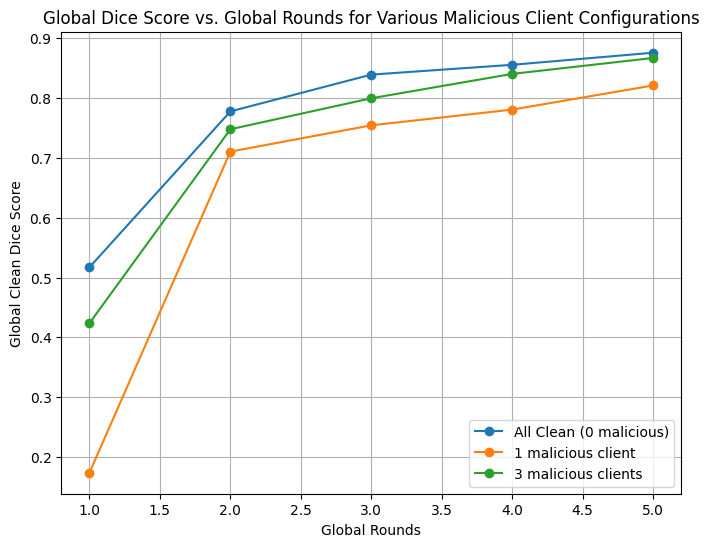

In [24]:
# Plotting the results: global round on x-axis, Dice score on y-axis.
rounds = list(range(1, num_global_rounds + 1))
plt.figure(figsize=(8, 6))
for label, dice_scores in results.items():
    plt.plot(rounds, dice_scores, marker="o", label=label)
plt.xlabel("Global Rounds")
plt.ylabel("Global Clean Dice Score")
plt.title("Global Dice Score vs. Global Rounds for Various Malicious Client Configurations")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#########################################
# New Experiment and Results Plotting   #
#########################################
if __name__ == "__main__":
    # Set experiment parameters.
    num_global_rounds = 5
    local_epochs = 2
    batch_size = BATCH_SIZE
    val_fraction = 0.2

    # Run the baseline (all clean) simulation.
    print("\n--- Running Baseline (All Clean, 0 malicious) Experiment ---")
    baseline_history = run_experiment(num_global_rounds,
                                      local_epochs,
                                      malicious_data_percentage=0.0,  # All clients clean
                                      num_malicious_clients=0,
                                      batch_size=batch_size,
                                      val_fraction=val_fraction)
    baseline_final = baseline_history[-1]
    print(f"Baseline final global Dice: {baseline_final:.4f}")

    # Define experiments for various malicious percentages.
    malicious_percentages = [0.5,0.3, 0.25, 0.2, 0.1]  # 30%, 25%, 20%, 10% malicious data
    client_configurations = [1,2,3]  # 1 malicious client and 3 malicious clients

    # Dictionary to hold experiment results for plotting.
    experiments_results = {}
    # List for saving table rows.
    table_data = []

    for num_mal_clients in client_configurations:
        for mal_percent in malicious_percentages:
            label = f"{num_mal_clients} malicious, {int(mal_percent*100)}% mal"
            print(f"\n--- Running Experiment: {label} ---")
            dice_history = run_experiment(num_global_rounds,
                                          local_epochs,
                                          malicious_data_percentage=mal_percent,
                                          num_malicious_clients=num_mal_clients,
                                          batch_size=batch_size,
                                          val_fraction=val_fraction)
            experiments_results[label] = dice_history
            final_dice = dice_history[-1]
            dice_drop = MANUAL_BASELINE_DICE - final_dice
            table_data.append({
                "Malicious Clients": f"{num_mal_clients} / {NUM_CLIENTS}",
                "Malicious Data Percentage": f"{int(mal_percent*100)}%",
                "Drop in Dice": dice_drop
            })

    #########################################
    # Plotting the Global Dice Curves       #
    #########################################
    rounds = list(range(1, num_global_rounds + 1))
    plt.figure(figsize=(10, 6))
    for label, dice_scores in experiments_results.items():
        plt.plot(rounds, dice_scores, marker="o", label=label)
    # Plot the baseline as a horizontal dashed line.
    plt.axhline(y=baseline_final, color="gray", linestyle="--", label="Baseline (All Clean)")
    plt.xlabel("Global Rounds")
    plt.ylabel("Global Clean Dice Score")
    plt.title("Global Dice Score vs. Global Rounds for Various Malicious Settings")
    plt.legend()
    plt.grid(True)
    plt.show()

    #########################################
    # Creating and Printing the Results Table#
    #########################################
    df_results = pd.DataFrame(table_data)
    print("\nSummary Table: Drop in Global Dice from the Baseline (MANUAL_BASELINE_DICE)")
    print(df_results.to_string(index=False))
